In [1]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 12.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%%capture
from PIL import Image
import os
import numpy as np
from pprint import pprint
from tqdm import tqdm #progress bar
import requests
import torch
from transformers import CLIPProcessor, CLIPModel
from transformers import AutoProcessor, LlavaForConditionalGeneration
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import csv
import os
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
# file path for web scraped data
filepath_pd = '/content/drive/MyDrive/capstone_project/palm_desert.txt'
filepath_cc = '/content/drive/MyDrive/capstone_project/cook_county_recycling_instruc.txt'

# file path for images
imagepath = '/content/drive/MyDrive/capstone_project/image_data/data_x.npy'
# file path for image labels
labelpath = '/content/drive/MyDrive/capstone_project/image_data/data_y.npy'

#filepath for model output
outputpath = '/content/drive/MyDrive/capstone_project/Notebooks/llava_output'

# getting recycling guide instructions
with open(filepath_pd, "r") as file:
  pd_instruc = file.read()

#with open(filepath_cc, "r") as file:
#  cc_instruc = file.read()

In [30]:
# getting images (loaded as numpy arrays)
images = np.load(open(imagepath, 'rb'))
labels = np.load(labelpath, allow_pickle=True)

label_names, integer_labels = np.unique(labels, return_inverse=True)

tensor_x = torch.Tensor(images) # transform to torch tensor
tensor_y = torch.tensor(integer_labels).long() #torch.Tensor(shuffled_labels)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size = 3, shuffle=True) # create dataloader

Feature batch shape: torch.Size([3, 128, 128, 3])
Labels batch shape: torch.Size([3])


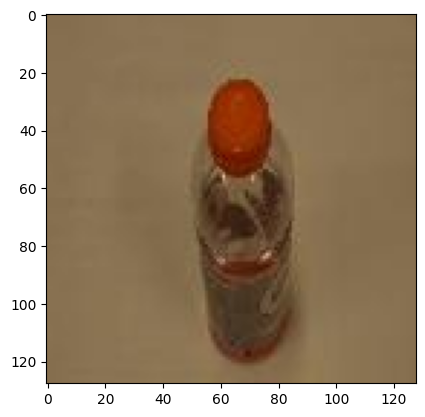

In [7]:
# Display image and label
features, labels = next(iter(my_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].numpy().astype(np.uint8) #.squeeze()
label = labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label_names[label]}")

In [34]:
unique, counts = np.unique(labels, return_counts=True)

d = dict(zip(unique, counts))
print(d)

{'aluminum_can': 70, 'boxes': 100, 'glass_bottle': 100, 'paper_cup': 59, 'plastic_bottle': 100, 'soda_can': 100}


In [8]:
def string_accuracy(actual, predicted):

    # Count the number of correct predictions
    correct_predictions = sum(a == p for a, p in zip(actual, predicted))

    # Calculate accuracy
    accuracy = correct_predictions / len(actual)

    return accuracy

Label: plastic_bottle


In [15]:
# Function to extract "ASSISTANT" responses
def extract_assistant_response(row):
    response = row['Pred']
    if "ASSISTANT:" in response:
        # Split on "ASSISTANT:" and take the second part, stripping whitespace
        assist = response.find("ASSISTANT:")
        assistant_response = response[assist + 11:].lower()
        if assistant_response == 'box': # replace box with boxes for alignment with labels
          assistant_response = 'boxes'
        return assistant_response
    return None

In [40]:
def get_cm_scores(df, title):
  cm = confusion_matrix(df['Label'], df['Prediction'])

  accuracy = accuracy_score(df['Label'], df['Prediction'])
  precision = precision_score(df['Label'], df['Prediction'], average='weighted')
  recall = recall_score(df['Label'], df['Prediction'], average='weighted')

  plt.figure(figsize=(6, 5))
  unique_classes = sorted(df['Label'].unique())
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title(title)
  plt.show()

  print(f'Accuracy: {accuracy:.2f}')
  print(f'Weighted Precision: {precision:.2f}')
  print(f'Weighted Recall: {recall:.2f}')

# Splitting up model components

## Part 1: Image classification

In [9]:
# list of item types in dataset with '_' removed because it slightly improved classification accuracy
captions = [c.replace('_', ' ') for c in label_names]
# need to map the string output back to the original format for comparison with labels
caption_map = {'boxes':'boxes', 'soda can':'soda_can', 'plastic bottle':'plastic_bottle', 'glass bottle':'glass_bottle', 'paper cup':'paper_cup', 'aluminum can':'aluminum_can'}

print(captions)

['aluminum can', 'boxes', 'glass bottle', 'paper cup', 'plastic bottle', 'soda can']


### CLIP - better for classification with specific options to choose from

In [ ]:
%%capture
cl_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
cl_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
inputs = cl_processor(
        text=captions, images=features, return_tensors="pt", padding=True
)

with torch.no_grad():
  with torch.autocast(device):
    outputs = cl_model(**inputs)

logits_per_image = outputs.logits_per_image            # image-text similarity score
probs = logits_per_image.softmax(dim=1)

In [ ]:
# mapping ids to correct caption / label
ids = torch.argmax(probs, dim=1)
pred_item = list(np.array(captions)[ids])
#print(item)

In [ ]:
# replace predicted string with equivalent label string
pred_caption = [caption_map.get(item, item) for item in pred_item]
label_caption = [label_names[l] for l in labels]
#label_caption

In [ ]:
accuracy = string_accuracy(label_caption, pred_caption)
print(accuracy) # this has ranged from 59-70% ONLY DONE ON 1 BATCH SO FAR (200 images)

0.63


In [ ]:
len(label_caption)

200

For all batches:

In [ ]:
total_correct = 0
total_samples = 0

# Iterate through batches
for b, batch in enumerate(my_dataloader):
    print('Batch', b)
    captions = captions  # List of captions for the batch
    images_pil = batch[0]    # List of images as NumPy arrays

    # Convert NumPy arrays to PIL Images
    #images_pil =  [to_pil(img) for img in images_tensor]

    # Process the inputs
    inputs = cl_processor(text=captions, images=images_pil, return_tensors="pt", padding=True)

    # Move to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cl_model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run inference
    with torch.no_grad():
        outputs = cl_model(**inputs)

    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)
    ids = torch.argmax(probs, dim=1)

    pred_item = list(np.array(captions)[ids.cpu()])
    pred_caption = [caption_map.get(item, item) for item in pred_item]
    label_caption = [label_names[l] for l in batch[1]]

    # Get image and text features
    #image_features = outputs.image_embeds
    #text_features = outputs.text_embeds

    # Compute similarity scores
    #similarity = torch.matmul(text_features, image_features.T)

    # Get predicted indices (the index of the highest score)
    #preds = similarity.argmax(dim=1)

    # Update total correct predictions and samples
    #total_correct += (preds == ground_truth.numpy()).sum()
    total_correct += sum(1 for str1, str2 in zip(pred_caption, label_caption) if str1 == str2) #(pred_caption == label_caption).astype(int).sum()
    total_samples += len(label_caption)

    print('Accuracy for batch', b, ':', total_correct/total_samples)

# Calculate accuracy
accuracy = total_correct / total_samples
print(f"\n\nOverall Accuracy: {accuracy * 100:.2f}%")


Batch 0
Accuracy for batch 0 : 0.645
Batch 1
Accuracy for batch 1 : 0.6525
Batch 2
Accuracy for batch 2 : 0.6465028355387523


Accuracy: 64.65%


### BLIP for Visual QA - better for open ended response

In [ ]:
from transformers import BlipProcessor, BlipForQuestionAnswering

processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base", torch_dtype=torch.float16).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [ ]:
#question = f"What item is in the image from the following list of options: {captions}?"
#question = f"Of these options: {captions}, which description best represents the item in the image?"
#question = "What type of food packaging item is this?"
question = f"This item is a: {captions}, which of these items is shown in the image?"

inputs = processor(shuffled_images[2], question, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(out[0], skip_special_tokens=True))

cup


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
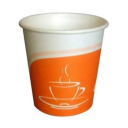

In [ ]:
shuffled_images[2]

In [ ]:
test_set = np.array([i for i in shuffled_images[:100]])
print(len(test_set))

100


In [ ]:
#question = f"This item is a: {captions}, which of these items is shown in the image?"
question = f"Describe the item in this image"

inputs = processor(test_set, question, return_tensors="pt").to("cuda", torch.float16)
output = model.generate(**inputs, max_new_tokens=100)

In [ ]:
pred = [processor.decode(i, skip_special_tokens=True) for i in output]
#print(pred)

#### Looking at different scoring methods for non-exact model output

In [ ]:
import nltk
from nltk.translate import meteor_score
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# reformat output
ref = [str(i[0]) for i in shuffled_labels[:100]]

score = meteor_score.meteor_score([ref], pred)
print(f'METEOR score: {score}')

METEOR score: 0.0


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# reformat output
refs = [[str(i[0])] for i in shuffled_labels[:100]]

bleu_score_corpus = corpus_bleu(refs, pred)
print(f'Corpus BLEU score: {bleu_score_corpus}')

Corpus BLEU score: 0.22888447430428757
Weighted BLEU score: 0


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install thefuzz

In [ ]:
from thefuzz import fuzz
ref = [str(i[0]) for i in shuffled_labels[:100]]
fuzz.ratio(ref, pred)

0

### LLaVa

From what I can tell, this model is not good for image classification.

In [10]:
model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [12]:
#item-specific prompt
#item_prompt = f"USER: <image>\n What item is shown in this image, here is a list of options you can choose from: {captions} \nASSISTANT:"
#item_prompt = f"USER: <image>\n Select the best caption for this image from this list: {captions} respond in 2 words \nASSISTANT:"
#item_prompt = f"USER: <image>\n Please output the material the item in the photo is made of and the type of object shown in the image from this list of options: {captions} \nASSISTANT:"

item_prompt = f"USER: <image>\n Tell me which of the following items is most likely to be the image. Select only 1 item from the following list: Aluminum Can, Box, Glass bottle, Paper cup, Plastic bottle, Soda can. Output only the item name.\nASSISTANT:"

In [11]:
# get model output and save in outputpath (folder)
def get_image_class(dataloader, item_prompt, max_new_tokens=100, outputpath=outputpath):
  for b, batch in enumerate(dataloader):
      output_list = []
      label_list = []
      images, labels = batch
      prompt = [item_prompt]*len(images)

      # Process the inputs
      inputs = processor(text=prompt,
                        images=images,
                        return_tensors='pt').to(0, torch.float16)

      # Run inference
      with torch.no_grad():
          outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)

      decoded_output = processor.batch_decode(outputs, skip_special_tokens=True)

      output_list.append(decoded_output)
      output_list = sum(output_list, []) # flatten list

      label_caption = [label_names[l] for l in labels] # getting text version of label
      label_list.append(label_caption)
      label_list = sum(label_list, []) # flatten list

      # Specify the filename
      filename = f'output_{b}_batch.csv'

      # Write to the CSV file
      with open(filename, mode='w', newline='') as file:
          writer = csv.writer(file)
          writer.writerow(['Pred', 'Label'])
          for item1, item2 in zip(output_list, label_list):
            writer.writerow([item1, item2])

      shutil.copy(filename, outputpath)

      print(f'Data exported to {filename}') # should get to 176 batches with batch length = 3 (30 min)

In [14]:
get_image_class(my_dataloader, item_prompt)

Data exported to output_0_batch.csv
Data exported to output_1_batch.csv
Data exported to output_2_batch.csv
Data exported to output_3_batch.csv
Data exported to output_4_batch.csv
Data exported to output_5_batch.csv
Data exported to output_6_batch.csv
Data exported to output_7_batch.csv
Data exported to output_8_batch.csv
Data exported to output_9_batch.csv
Data exported to output_10_batch.csv
Data exported to output_11_batch.csv
Data exported to output_12_batch.csv
Data exported to output_13_batch.csv
Data exported to output_14_batch.csv
Data exported to output_15_batch.csv
Data exported to output_16_batch.csv
Data exported to output_17_batch.csv
Data exported to output_18_batch.csv
Data exported to output_19_batch.csv
Data exported to output_20_batch.csv
Data exported to output_21_batch.csv
Data exported to output_22_batch.csv
Data exported to output_23_batch.csv
Data exported to output_24_batch.csv
Data exported to output_25_batch.csv
Data exported to output_26_batch.csv
Data export

In [16]:
# grab and concat output
df_concat = pd.concat([pd.read_csv(f) for f in os.listdir(outputpath)])

# Apply the function and create a new column
df_concat['Prediction'] = df_concat.apply(extract_assistant_response, axis=1)

df = df_concat[['Prediction', 'Label']].reset_index(drop=True)
df['Label'] = df['Label'].str.replace('_', ' ', regex=False)

# Display the resulting DataFrame
df.head()

,Prediction,Label
0,boxes,boxes
1,aluminum can,glass bottle
2,aluminum can,plastic bottle
3,plastic bottle,plastic bottle
4,aluminum can,boxes


In [22]:
# replacing soda can with aluminum can
df2 = df[['Prediction', 'Label']]
df2['Label'] = df2['Label'].str.replace('soda can', 'aluminum can', regex=False)
df['Prediction'] = df2['Prediction'].str.replace('soda can', 'aluminum can', regex=False)
df2.head()

,Prediction,Label
0,boxes,boxes
1,aluminum can,glass bottle
2,aluminum can,plastic bottle
3,plastic bottle,plastic bottle
4,aluminum can,boxes


In [23]:
# accuracy

base_accuracy = string_accuracy(df['Label'], df['Prediction'])
al_accuracy = string_accuracy(df2['Label'], df2['Prediction'])
print('Accuracy:', base_accuracy)
print('Accuracy when grouping soda and aluminum can:', al_accuracy)

Accuracy: 0.5406427221172023
Accuracy when grouping soda and aluminum can: 0.7277882797731569


In [42]:
print("Unique classes in true labels:", sorted(df2['Label'].unique()))
print("Unique classes in predictions:", sorted(df2['Prediction'].unique()))

Unique classes in true labels: ['aluminum can', 'boxes', 'glass bottle', 'paper cup', 'plastic bottle']
Unique classes in predictions: ['aluminum can', 'boxes', 'glass bottle', 'paper cup', 'plastic bottle']


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


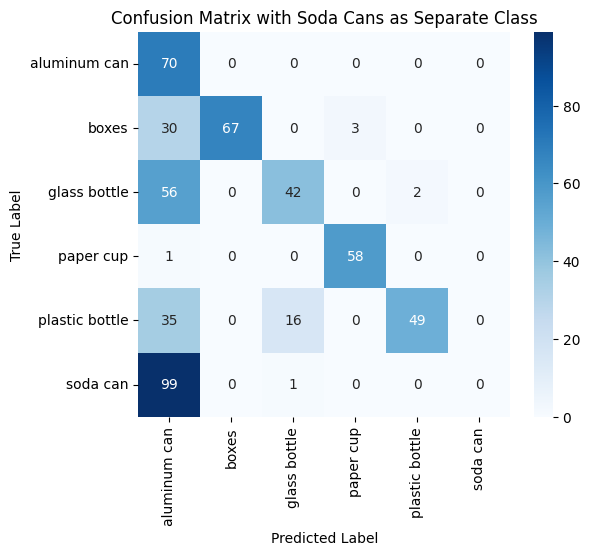

Accuracy: 0.54
Weighted Precision: 0.64
Weighted Recall: 0.54


In [39]:
get_cm_scores(df,title='Confusion Matrix with Soda Cans as Separate Class')

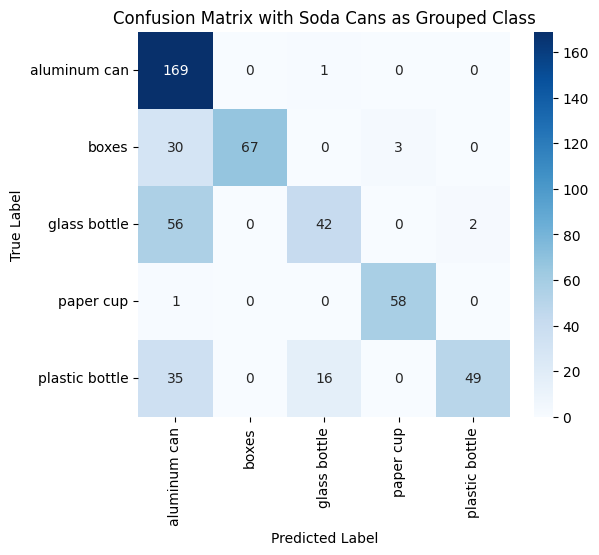

Accuracy: 0.73
Weighted Precision: 0.80
Weighted Recall: 0.73


In [41]:
get_cm_scores(df2,title='Confusion Matrix with Soda Cans as Grouped Class')

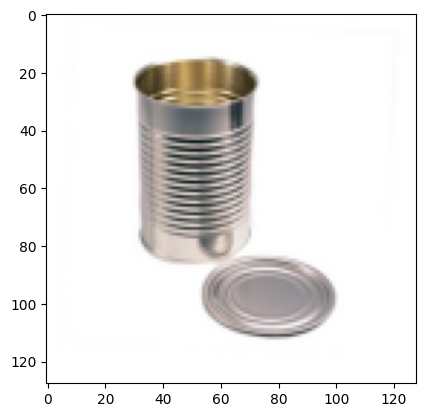

In [ ]:
#looking at some of the images

for b, batch in enumerate(my_dataloader):
    images = batch[0]
    for i in images:
      plt.imshow(i.numpy().astype(np.uint8))
    break

## Part 2: Bin Classification

In [ ]:
print(prompt_instruct)

Given the following instructions for recycling in Palm Desert: 
 {'Paper': ', White and colored paper, Phone books, Magazines, Junk Mail, Envelopes, File folders, Cardboard (flattened), Cartons (milk, juice, & broth), Books (remove hard covers or binding), Cardboard boxes, e.g. cereal, etc.,', 'Plastic': ', Styrofoam packing blocks, Plastic medicine bottles (empty), Plastic bottles numbered 1-7 (remove plastic film or wrap),', 'Metal&Glass': ', Aluminum, steel, and tin cans, Clean aluminum foil, Glass bottles and jars (remove lids),'} 
 Use these instructions to explain how to recycle the item shown in the image.


In [ ]:
# PROMPTS

#bin_prompt = f"USER: <image>\n{prompt_instruct}\n Should this item be thrown in the recycling bin or trash bin based on the inputted recycling guide?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n{prompt_instruct}\n This is a {shuffled_labels[0]}. Should this be thrown in the recycling bin?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n{prompt_instruct}\n Should this item be recycled based on the inputted recycling guide?\nASSISTANT:"
#bin_prompt = f"USER: <image>\n Should this item be recycled based on the inputted recycling guide?\n{prompt_instruct}\nASSISTANT:"

prompt_instruct2 = f"Given the following instructions for recycling in {location}: \n The following items can be recycled: {pd_instruc} \n Determine if the item should be disposed of in the recycling or trash."
bin_prompt = f"USER: <image>\n{prompt_instruct2}\n This is a {shuffled_labels[0][0]}. Should this be thrown in the recycling bin?\nASSISTANT:"

In [ ]:
#inputs = processor(text=bin_prompt, images=shuffled_images[0], return_tensors='pt', max_length=512, truncation=True).to(0, torch.float16)
#output = model.generate(**inputs, max_new_tokens=200)#, temperature=0)
#decoded_output = processor.decode(output[0], skip_special_tokens=True)
#print(decoded_output[decoded_output.find('ASSISTANT:'):])

ASSISTANT: Based on the instructions provided, the item should be disposed of in the recycling bin. The box is made of cardboard, which is a type of paper and is considered recyclable. It is important to recycle cardboard boxes to reduce waste and promote a more sustainable environment.


In [ ]:
# Creating a test set to avoid crashing colab
test_set = np.array([i for i in shuffled_images[:3]])
prompts = [f"USER: <image>\n{prompt_instruct2}\n This is a {item[0]}.\nASSISTANT:" for item in shuffled_labels[:3]] # diff item class with each image
#prompts = [bin_prompt] * len(test_set) # for the same prompt

inputs = processor(images=test_set, text=prompts, return_tensors="pt", padding=True).to(0, torch.float16)
#inputs = processor(prompt, img, return_tensors='pt').to(0, torch.float16)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=200)

# decoding the generated output
generated_texts = processor.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
for res in generated_texts:
  print(res[res.find('ASSISTANT:'):])

ASSISTANT: The item should be disposed of in the recycling. The boxes are made of cardboard, which is a type of paper. Therefore, it should be placed in the recycling bin along with other paper items.
ASSISTANT: The item should be disposed of in the recycling.
ASSISTANT: Based on the instructions provided, the aluminum can should be disposed of in the recycling bin. Aluminum cans are typically made of recyclable materials and can be recycled to create new products. To recycle the can, it should be flattened and placed in the designated recycling bin along with other recyclable materials like paper, plastic, and metal.


In [ ]:
# same as above without images

# Creating a test set to avoid crashing colab
test_set = np.array([i for i in shuffled_images[:3]])
prompts = [f"USER: {prompt_instruct2}\n This is a {item[0]}.\nASSISTANT:" for item in shuffled_labels[:30]] # diff item class with each image
#prompts = [bin_prompt] * len(test_set) # for the same prompt

inputs = processor(text=prompts, return_tensors="pt", padding=True).to(0, torch.float16)
#inputs = processor(prompt, img, return_tensors='pt').to(0, torch.float16)

with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=200)

# decoding the generated output
generated_texts = processor.batch_decode(outputs, skip_special_tokens=True, clean_up_tokenization_spaces=False)

TypeError: is_floating_point(): argument 'input' (position 1) must be Tensor, not NoneType

Where I am at:


*   Don't need the images for this part at all, which opens up the possibility of using less heavy models **OR** improving this one's ability to classify images
*   Can use fuzzymatching /something similar to see if output contains "recycling bin".



## Part 3: Recycling Instructions

array([[[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [138, 115,  83],
        [137, 114,  82],
        [136, 113,  81]],

       [[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [138, 115,  83],
        [137, 114,  82],
        [137, 114,  82]],

       [[142, 119,  87],
        [142, 119,  87],
        [142, 119,  87],
        ...,
        [139, 116,  84],
        [138, 115,  83],
        [138, 115,  83]],

       ...,

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [148, 124,  90],
        [145, 121,  87],
        [143, 119,  85]],

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [147, 123,  89],
        [145, 121,  87],
        [143, 119,  85]],

       [[143, 120,  88],
        [143, 120,  88],
        [143, 120,  88],
        ...,
        [147, 123,  89],
        [145, 121,  87],
        [143, 119,  85]]], dtype=uint8)
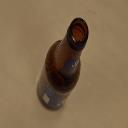

In [ ]:
img

In [ ]:
inputs = processor(img, prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
decoded_output = processor.decode(output[0], skip_special_tokens=True)
#assist = decoded_output.find('ASSISTANT:')
#instructs.append(decoded_output[assist:])
print(decoded_output)

chlorophyll


### OLD

In [ ]:
# check if there is a better way to apply this

item_type = []
bin = []
instructs = [] # starting with this only

# probably the slowest way to do it so need to optimize
i=0
while i < 3:
  for img in images:
    inputs = processor(prompt, img, return_tensors='pt').to(0, torch.float16)
    output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
    decoded_output = processor.decode(output[0][2:], skip_special_tokens=True)
    assist = decoded_output.find('ASSISTANT:')
    instructs.append(decoded_output[assist:])
    i += 1
  #break

In [ ]:
prompt = f"USER: <image>\n{prompt_w_instruc}\nWhat is in the image and can it be recycled, assume things not in instructions cannot be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling in Palm Desert: \n'
 ' What Items Can Be Recycled\n'
 '\n'
 'Paper\t\n'
 '- White and colored paper\n'
 '- Phone books\n'
 '- Magazines\n'
 '- Junk Mail\n'
 '- Envelopes\n'
 '- File folders\n'
 '- Cardboard (flattened)\n'
 '- Cartons (milk, juice, & broth)\n'
 '- Books (remove hard covers or binding)\n'
 '- Cardboard boxes, e.g. cereal, etc.\n'
 '\n'
 'Plastic\n'
 '- Styrofoam packing blocks\n'
 '- Plastic medicine bottles (empty)\n'
 '- Plastic bottles numbered 1-7 (remove plastic film or wrap)\n'
 '\n'
 'Metal & Glass\n'
 '- Aluminum, steel, and tin cans\n'
 '- Clean aluminum foil\n'
 '- Glass bottles and jars (remove lids)\n'
 'What is in the image and can it be recycled, assume things not in '
 'instructions cannot be recycled?\n'
 'ASSISTANT: In the image, there is a white cup made of paper. Based on the '
 'instructions provided, the cup can be recycled as it is made of paper. '
 'However, it is important to note that ot

In [ ]:
## aluminum can

prompt = f"USER: <image>\n{prompt_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im_2, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling in Palm Desert: \n'
 ' What Items Can Be Recycled\n'
 '\n'
 'Paper\t\n'
 '- White and colored paper\n'
 '- Phone books\n'
 '- Magazines\n'
 '- Junk Mail\n'
 '- Envelopes\n'
 '- File folders\n'
 '- Cardboard (flattened)\n'
 '- Cartons (milk, juice, & broth)\n'
 '- Books (remove hard covers or binding)\n'
 '- Cardboard boxes, e.g. cereal, etc.\n'
 '\n'
 'Plastic\n'
 '- Styrofoam packing blocks\n'
 '- Plastic medicine bottles (empty)\n'
 '- Plastic bottles numbered 1-7 (remove plastic film or wrap)\n'
 '\n'
 'Metal & Glass\n'
 '- Aluminum, steel, and tin cans\n'
 '- Clean aluminum foil\n'
 '- Glass bottles and jars (remove lids)\n'
 'What is in the image and can it be recycled?\n'
 'ASSISTANT: The image features a canned food item, which is typically made of '
 'metal. This can be recycled as part of the metal and glass recycling '
 'category. To recycle the can, it should be removed from the food item and '
 'placed in a recycli

In [ ]:
with open("cook_county_recycling_instruc.txt", "r", encoding = 'utf-8') as file:
  cc_instruc = file.read()

In [ ]:
prompt_start_w_instruc = f"Given the following instructions for recycling: \n {cc_instruc}"

In [ ]:
prompt = f"USER: <image>\n{prompt_start_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling: \n'
 ' FAQs: Recycling and Proper Disposal CAPS  \n'
 '      \n'
 '\n'
 '  Credit: Recycle by City Always replace your cap onto the empty and clean '
 'plastic bottle it came from. Then, place into your recycling bin to ensure '
 'both plastic components are successfully processed at your local recycling '
 'facility. CLEAN, EMPTY AND DRY RECYCLABLES\n'
 '      \n'
 '\n'
 '  Before you place your recyclable item into your bin, rinse it clean and '
 'allow it to dry. Soap is not necessary. Clean recyclables reduce '
 'contamination of recycling batches. Contamination can result in recyclable '
 'materials being sent to the landfill.SHREDDED PAPER\n'
 '      \n'
 '\n'
 '  Shredded paper should not be placed in your curbside recycling bin. The '
 'small size of the fragmented pieces does not allow for proper sorting at the '
 'recycling facility. Generally, items smaller than a credit card should not '
 'be put in the recycling 

In [ ]:
# aluminum can image experimentation

prompt = f"USER: <image>\n{prompt_start_w_instruc}\nWhat is in the image and can it be recycled?\nASSISTANT:"
inputs = processor(prompt, test_im_2, return_tensors='pt').to(0, torch.float16)

output = model.generate(**inputs, max_new_tokens=300, do_sample=False)
pprint(processor.decode(output[0][2:], skip_special_tokens=True))

('ER:  \n'
 'Given the following instructions for recycling: \n'
 ' FAQs: Recycling and Proper Disposal CAPS  \n'
 '      \n'
 '\n'
 '  Credit: Recycle by City Always replace your cap onto the empty and clean '
 'plastic bottle it came from. Then, place into your recycling bin to ensure '
 'both plastic components are successfully processed at your local recycling '
 'facility. CLEAN, EMPTY AND DRY RECYCLABLES\n'
 '      \n'
 '\n'
 '  Before you place your recyclable item into your bin, rinse it clean and '
 'allow it to dry. Soap is not necessary. Clean recyclables reduce '
 'contamination of recycling batches. Contamination can result in recyclable '
 'materials being sent to the landfill.SHREDDED PAPER\n'
 '      \n'
 '\n'
 '  Shredded paper should not be placed in your curbside recycling bin. The '
 'small size of the fragmented pieces does not allow for proper sorting at the '
 'recycling facility. Generally, items smaller than a credit card should not '
 'be put in the recycling 